# Mapping vehicles with `solaris` and the `cowc` dataset

`solaris` can assist with tasks beyond foundational mapping. Here, we'll go through a full exercise of preprocessing the Cars Overhead With Context (`cowc`) dataset, training a segmentation model with `solaris`, mapping vehicles in a previously unseen test city, and finally scoring our results.


Let's start with downloading our data.  The `cowc` dataset can be [downloaded here.](ftp://gdo152.ucllnl.org/cowc/datasets/ground_truth_sets/)  Save it to a location where you will be able to preprocess the data and enable your GPU to find it.

Once all the data in the `ground_truth_sets/` directory is downloaded, we'll import our packages.

In [1]:
import solaris as sol
import os
import glob
import gdal
from tqdm import tqdm
import cv2
import shutil
import pandas as pd
import numpy as np
from skimage.morphology import square, dilation
from matplotlib import pyplot as plt
from solaris.eval.iou import calculate_iou
import geopandas as gpd

### Specify our directories for pre processing

In [2]:
root= ".../cowc/datasets/ground_truth_sets/"  ##cowc ground_truth_sets location after download
masks_out= ".../cowc/masks" ##output location for your masks for training
images_out= ".../cowc/tiles" ##output location for your tiled images for testing
masks_test_out= ".../cowc/masks_test" ##output location for your masks for testing
images_test_out= ".../cowc/tiles_test" ##output location for your tiled images for testing

### Initialize a tiling function
Below is a function for tiling, solaris presently does not handle non-georeferenced pngs, but will in the future.  This is a hold-over function until then.

In [ ]:
def geo_tile(untiled_image_dir, tiles_out_dir, tile_size=544,
             overlap=0.2, search=".png",Output_Channels=[1,2,3]):
    """Function to tile a set of images into smaller square chunks with embedded georeferencing info
    allowing an end user to specify the size of the tile, the overlap of each tile, and when to discard
    a tile if it contains blank data.
    Arguments
    ---------
    untiled_image_dir : str
        Directory containing full or partial image strips that are untiled.
        Imagery must be georeferenced.
    tiles_out_dir : str
        Output directory for tiled imagery.
    tile_size : int
        Extent of each tile in both X and Y directions in units of pixels.
        Defaults to ``544`` .
    overlap : float
        The amount of overlap of each tile in float format.  Should range between 0 and <1.
        Defaults to ``0.2`` .
    search : str
        A string with a wildcard to search for files by type
        Defaults to ".png"
    Output_Channels : list
        A list of the number of channels to output, 1 indexed.
        Defaults to ``[1,2,3]`` .
    Returns
    -------
    Tiled imagery directly output to the tiles_out_dir
    """
    if not os.path.exists(tiles_out_dir):
        os.makedirs(tiles_out_dir)

    os.chdir(untiled_image_dir)
    search2 = "*" + search
    images = glob.glob(search2)
    tile_size = int(tile_size)

    for stackclip in images:
        print(stackclip)
        interp = gdal.Open(os.path.abspath(stackclip))
        width = int(interp.RasterXSize)
        height = int(interp.RasterYSize)
        count = 0
        for i in range(0, width, int(tile_size * (1 - overlap))):
            for j in range(0, height, int(tile_size * (1 - overlap))):
                Chip = [i, j, tile_size, tile_size]
                count += 1
                Tileout = tiles_out_dir + "/" + \
                    stackclip.split(search)[0] + "_tile_" + str(count) + ".tif"
                output = gdal.Translate(Tileout, stackclip, srcWin=Chip, bandList=Output_Channels)
                del output
    print("Done")

### Orgainze our data
The `cowc` dataset is a bit cluttered to start, some reogranization helps us down the road for smoother pre-processing of the dataset.

In [ ]:
os.chdir(root)
dirs=glob.glob("*/")

for directory in dirs:
    os.chdir(directory)
    if not os.path.exists("Images"):
        os.makedirs("Images")
        os.makedirs("Masks")
        os.makedirs("Extras")
    xcfs=glob.glob("*.xcf")
    txts=glob.glob("*.txt")
    os.chdir("Images")
    negatives=glob.glob("*Negatives.png")
    masks=glob.glob("*Annotated_Cars.png")
    for xcf in xcfs:
        shutil.move(xcf,os.path.join(root,directory,"Extras",xcf))
    for txt in txts:
        shutil.move(txt,os.path.join(root,directory,"Extras",txt))
    for negative in negatives:
        shutil.move(negative,os.path.join(root,directory,"Extras",negative))
    for mask in masks:
        shutil.move(mask,os.path.join(root,directory,"Masks",mask))
    images=glob.glob("*.png")
    for image in images:
        shutil.move(image,os.path.join(root,directory,"Images",image))
    os.chdir(root)

### Tile our masks and convert them to GeoTiffs
Presently `solaris` works with GeoTiffs exclusively, so converting pngs into this tifs is required to start.  Furthermore tiling is required to feed our neural network. We will tile our masks and images sequentially, this process may take some time depending on your compute resources.

In [ ]:
for directory in dirs:
    if directory != "Utah_AGRC":
        directory = os.path.join(root,directory,"Masks")
        print(directory)
        geo_tile(directory, masks_out, tile_size=512, overlap=0.1,search="*.png",Output_Channels=[1])
    else:
        directory = os.path.join(root,directory,"Masks")
        print(directory)
        geo_tile(directory, masks_out, tile_size=512, overlap=0,search="*.png",Output_Channels=[1]) #No overlap for testing.

In [ ]:
for directory in dirs:
    if directory != "Utah_AGRC":
        directory = os.path.join(root,directory,"Images")
        print(directory)
        geo_tile(directory, images_out, tile_size=512, overlap=0.1,search="*.png",Output_Channels=[1,2,3])
    else:
        directory = os.path.join(root,directory,"Images")
        print(directory)
        geo_tile(directory, images_out, tile_size=512, overlap=0,search="*.png",Output_Channels=[1,2,3])

### Dialate our masks to increase the size of our labels
Here we will perform a [simple morphological dialation filter](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#dilation) to increase our label size.  This will make our masks large enough for our neural network to detect, but not large enough so they start to overlap one another when cars are located in close proximity to one another.

In [ ]:
driver = gdal.GetDriverByName("GTiff")
os.chdir(masks_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    band=dilation(band, square(9))
    im_out = driver.Create(image,band.shape[1],band.shape[0],1,gdal.GDT_Byte)
    im_out.GetRasterBand(1).WriteArray(band)
    del im_out

### Calculate some basic statistics for z-scoring (normalizing) our imagery
[Z-scoring](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) and normalizing our imagery can help to standardize it, improve generalizability, and potentially the transferability of a model to another location. It also helps to soften overly bright or dark areas.

In [ ]:
M1=[]
M2=[]
M3=[]
S1=[]
S2=[]
S3=[]
driver = gdal.GetDriverByName("GTiff")
os.chdir(images_out)
images=glob.glob("*.tif")
for image in images:
    band=gdal.Open(image).ReadAsArray()
    M1.append(np.mean(band[0,:,:]))
    M2.append(np.mean(band[1,:,:]))
    M3.append(np.mean(band[2,:,:]))
    S1.append(np.std(band[0,:,:]))
    S2.append(np.std(band[1,:,:]))
    S3.append(np.std(band[2,:,:]))

print("Save these numbers for your solaris.yml file for training and z-scoring (normalizing) your imagery")
print(np.mean(M1)/255)
print(np.mean(M2)/255)
print(np.mean(M3)/255)
print(np.mean(S1)/255)
print(np.mean(S2)/255)
print(np.mean(S3)/255)

### Hold out a city for testing
Here we hold out Salt Lake City, Utah as a test city, and do some simple data reogranization.

In [ ]:
if not os.path.exists(images_test_out):
        os.makedirs(images_test_out)
os.chdir(images_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(images_test_out,image)
    shutil.move(image, output)

if not os.path.exists(masks_test_out):
        os.makedirs(masks_test_out)
os.chdir(masks_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(masks_test_out,image)
    shutil.move(image, output)

### Review some of our masks and images
We can now review some our masks and images, you can change the integer value in the filename to see different tiles easily.

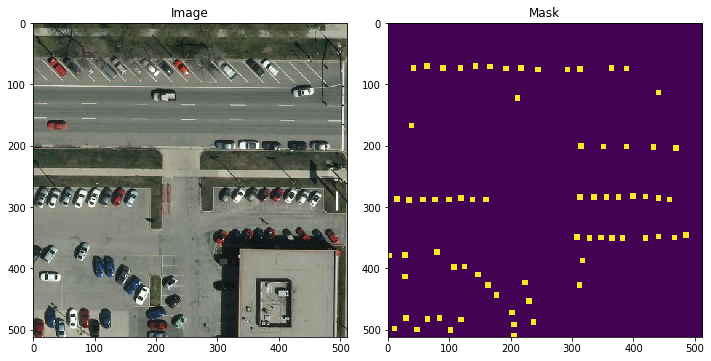

In [3]:
image = os.path.join(images_test_out,"12TVL240120_tile_518.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars_tile_518.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.tight_layout()

### Create a csv file that lists our images and our masks for training and testing
`solaris` requires our images and masks to be organized coherently and documents where each image is in a tabular csv format.  These csvs will be linked to in our yml file and can then be used to read in the data.

In [ ]:
data = []
images = []
image_folder=images_out
label_folder=masks_out
os.chdir(label_folder)
labels=glob.glob("*.tif")
for x in labels:
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        
for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"train_data_cowc2.csv"))

In [ ]:
data = []
images = []
image_folder=images_test_out
label_folder=masks_test_out
os.chdir(label_folder)
labels=glob.glob("*.tif")
for x in labels:
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        
for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"test_data_cowc2.csv"))

### Edit your .yml file and begin training your model
An [example yml file is provided here](https://github.com/jshermeyer/solaris_cowc/blob/master/xdxd_vehicleDetection.yml). Be sure the train paramenter is set to `True`.  Furthermore, be sure to pass the paths to your csvs that you just created into the `training_data_csv` and `inference_data_csv` prompts.  Optionally you may want to alter the `batch_size` or `val_holdout_frac` which is the fraction of images randomly sampled out of your training set to help your model learn as it trains.  Also ensure that your `Normalize` values are correct.

When you're ready, set the path you your modified yml file and run the prompt below.  Training time can take multiple hours.

In [ ]:
config = sol.utils.config.parse('/path/to/yml/xdxd_vehicleDetection.yml')
trainer = sol.nets.train.Trainer(config)
trainer.train()

### Time to inference
Be sure to edit your yml to enable infer mode and then we can start inferencing to find the vehicles in Salt Lake City.

In [ ]:
inf_df = sol.nets.infer.get_infer_df(config)
inferer = sol.nets.infer.Inferer(config)
inferer(inf_df)

### Specify our directories for post-processing

In [4]:
inference_output=".../cowc/inference_out"  ## The location that you output inference results to as specified in your yml.
inference_output_bin=".../cowc/inference_out_binary"  ## A location to store binarized outputs
inference_polygon_dir=".../cowc/inference_polys" ## Outputs polygonized
ground_truth_polygon_dir=".../cowc/ground_truth_polys" ## Ground Truth Outputs polygonized

### Post-processing- binarize our masks and convert them to polygons
Here we will binarize our outputs and convert a mask to a 1/0 value for car/no car.  Following this we will convert the masks to polygons.  You may want to adjust the cutoff value for binarization based on your own experiments or change this if you chose not to z-score your imagery.

In [ ]:
from solaris.vector.mask import mask_to_poly_geojson
driver = gdal.GetDriverByName("GTiff")

os.chdir(inference_output_bin)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    band[np.where((band > 0))] = 1  ### Note that these values may be model specific and change slightly due to reimplementations.  For simplicity I threshold at 0.
    band[np.where((band <= 0))] = 0
    im_out = driver.Create(os.path.join(inference_output_bin,image),band.shape[1],band.shape[0],1,gdal.GDT_Byte)
    im_out.GetRasterBand(1).WriteArray(band)
    del im_out
    output=os.path.join(inference_polygon_dir,image.split(".")[0]+".geojson") 
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')
        
        
os.chdir(masks_test_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    output=os.path.join(ground_truth_polygon_dir,image.split(".")[0]+".geojson") 
    image=image.split("_Annotated_Cars")[0]+image.split("_Annotated_Cars")[1]
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')

### Check out our results
Below we can inspect our results, and compare vs. the ground truth mask.  Again the integer value can be changed in each filename to inspect different tiles.

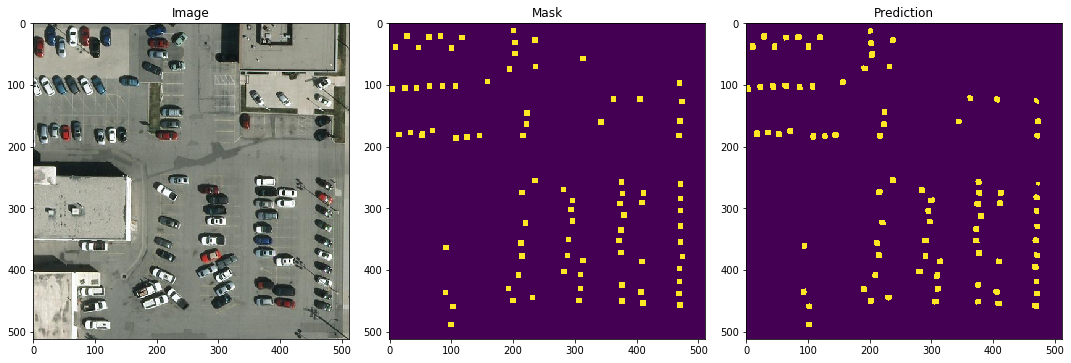

In [5]:
image = os.path.join(images_test_out,"12TVL240120_tile_519.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars_tile_519.tif")
prediction = os.path.join(inference_output_bin,"12TVL240120_tile_519.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()
prediction = gdal.Open(prediction).ReadAsArray()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(prediction)
ax[2].set_title('Prediction')
plt.tight_layout()

### Initialize a few more functions for scoring our results. 
Here we will work with the [solaris.eval.iou.calculate_iou()](../../api/eval.rst#solaris.eval.iou) function to calculate [intersection over union](https://en.wikipedia.org/wiki/Jaccard_index) and from this [precision and recall.](https://en.wikipedia.org/wiki/Precision_and_recall)  This can be used to score how well our model is performing at detecting cars.
The calculate_ious function's arguments:

- `pred_poly` : A `shapely.Polygon`.  This is a prediction polygon to test.
- `test_data_GDF` : A `geopandas.GeoDataFrame`.  This is GeoDataFrame of ground truth polygons to test ``pred_poly`` against.

Using the function as is will calculate precision, but we can actually "invert" the inputs to calculate recall as well.  For the recall caluclation instead of supplying a prediciton polygon we will supply a ground-truth polygon.  Furthermore, instead of supplying a ground truth geodataframe containing all of our ground truth polygons for a tile we will supply a geodataframe containing all of the prediction polygons for a tile.

We can initialize the functions below.

In [ ]:
#Wrapper functions for calculate_iou

def precision_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(proposal_polygons_dir)
    search = "*" + file_format
    proposal_geojsons=glob.glob(search)
    for geojson in tqdm(proposal_geojsons):
        ground_truth_poly = os.path.join(groundtruth_polygons_dir,geojson)
        if os.path.exists(ground_truth_poly):
            ground_truth_gdf=gpd.read_file(ground_truth_poly)
            proposal_gdf=gpd.read_file(geojson)
            for index, row in (proposal_gdf.iterrows()):
                iou=calculate_iou(row.geometry, ground_truth_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious

def recall_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(groundtruth_polygons_dir)
    search = "*" + file_format
    gt_geojsons=glob.glob(search)
    for geojson in tqdm(gt_geojsons):
        proposal_poly = os.path.join(proposal_polygons_dir,geojson)
        if os.path.exists(proposal_poly):
            proposal_gdf=gpd.read_file(proposal_poly)
            gt_gdf=gpd.read_file(geojson)
            for index, row in (gt_gdf.iterrows()):
                iou=calculate_iou(row.geometry, proposal_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious
    
def f1_score(precision_ious,recall_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    
    items=[]
    for i in recall_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    recall= np.mean(items)
    
    f1 = 2* precision * recall/(precision + recall)
    return f1

def simple_average_precision(precisions_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    return precision

### Score our results
As a final step we can score our outputs against the ground truth to report scores.  Without these scores all you really have is a pretty picture.  We report both an [F1 Score](https://en.wikipedia.org/wiki/F1_score) and an [average precision score](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision).

In [ ]:
# Score our results
precision_ious = precision_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
recall_ious = recall_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
print(f1_score(precision_ious,recall_ious,threshold=0.25), "F1 Score@0.25")
print(f1_score(precision_ious,recall_ious,threshold=0.5), "F1 Score@0.5") ## The traditional SpaceNet metric
print(simple_average_precision(precision_ious,threshold=0.25), "AP@0.25") ## Acceptable for small objects like cars!
print(simple_average_precision(precision_ious,threshold=0.5), "AP@0.5")